# Preamble

In [482]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from functions.read_g4bl_data import readTraceData
from functions.read_g4bl_data import readDetData
from functions.set_plot_settings import setPlotSettings
setPlotSettings(font=True)

# Location of G4bl output:
dir = 'g4bl-output/'

# Figure directory:
fig_dir = 'figures/'

# Number of detectors:
ndet = 31

In [483]:
# Choose to cut on p_total:
cuts = True

# Define cuts (MeV/c):
low_p_cut = 150
high_p_cut = 350

### Load detector data

In [484]:
x_vals = []; y_vals = []; z_vals = []; r_vals = []
px_vals = []; py_vals = []; pz_vals = []; ptotal_vals = []
t_vals = []
xp_vals = []; yp_vals = []
pdgids = []
for i in range(ndet):
    data = readDetData(dir+'out'+str(i+1)+'.txt', cuts=cuts, low_p_cut=low_p_cut, high_p_cut=high_p_cut)

    # Drop everything that is not mu+:
    data = data[data.PDGid == -13]

    x_vals.append(data['x'].values); y_vals.append(data['y'].values); z_vals.append(data['z'].values) # mm
    r_vals.append(data['r'].values) # mm
    px_vals.append(data['px'].values); py_vals.append(data['py'].values); pz_vals.append(data['pz'].values) # MeV/c
    ptotal_vals.append(data['ptotal'].values) # Mev/c
    t_vals.append(data['t'].values) # ns
    xp_vals.append(data['xp'].values); yp_vals.append(data['yp'].values) # radians
    pdgids.append(data['PDGid'].values)

    del data

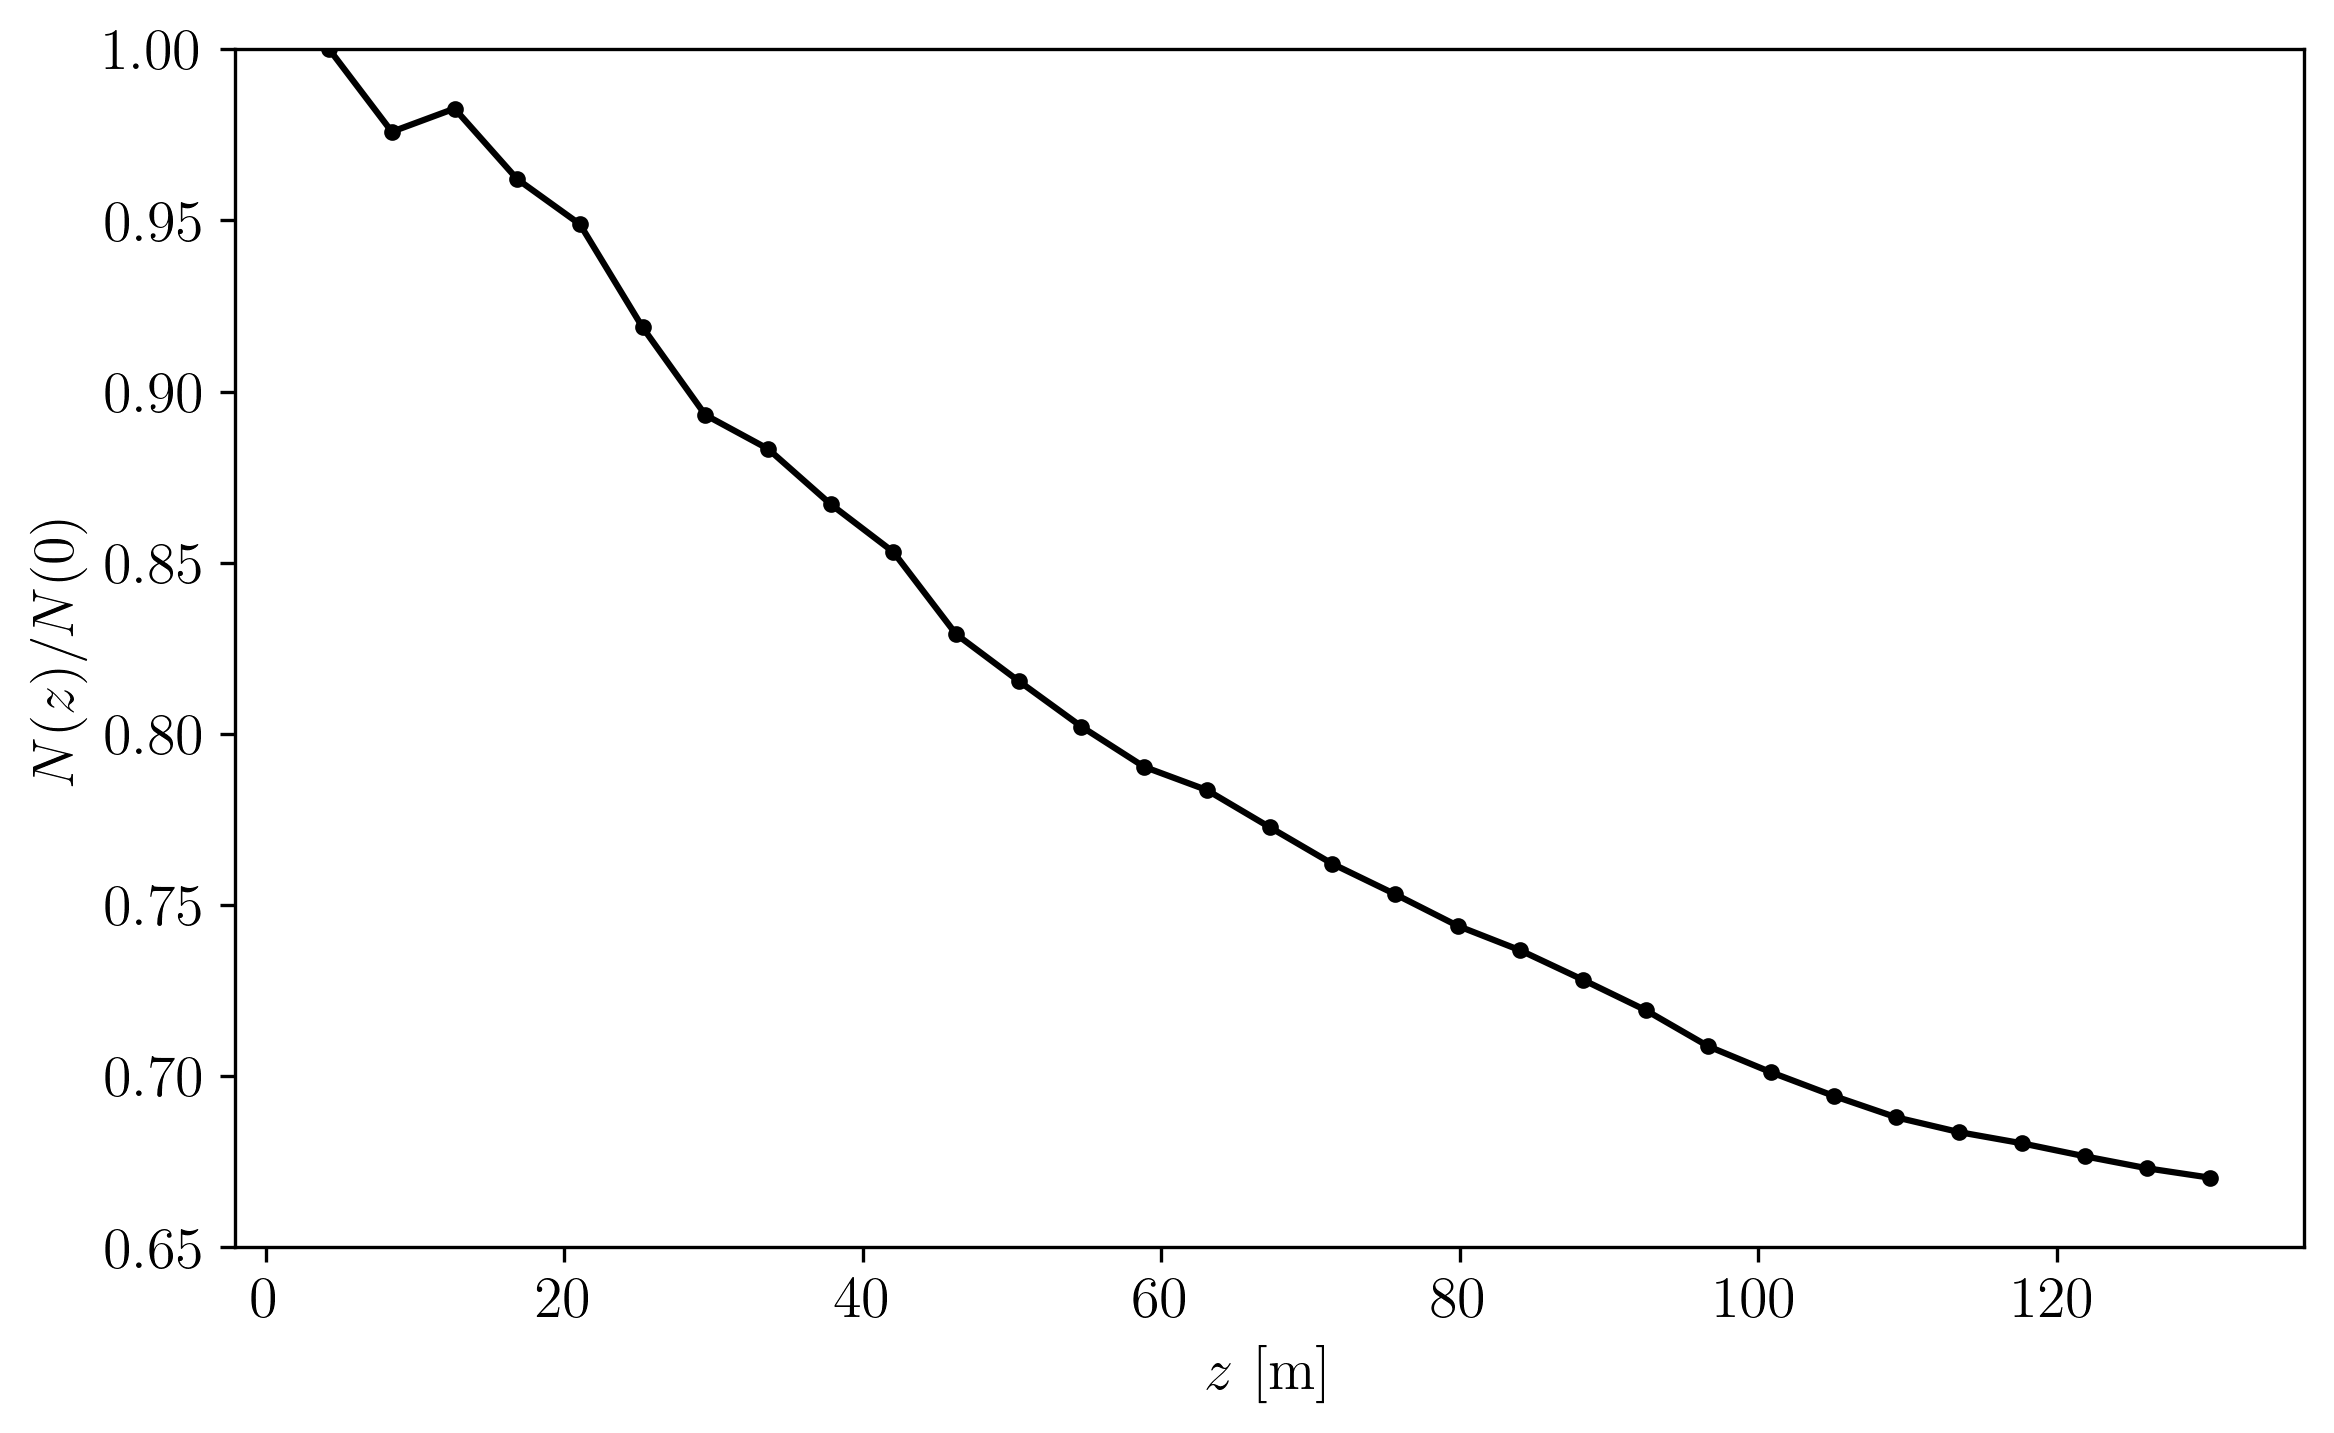

In [485]:
z_vals_m = [i[0]/1000 for i in z_vals]
trans = [(len(i)/len(z_vals[0])) for i in z_vals]

# Plot transmission rate vs. z:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(z_vals_m,trans,marker='.',color='black')
plt.xlabel('$z$ [m]')
plt.ylabel('$N(z)/N(0)$')
plt.ylim((0.65,1))
# plt.ylim((0.4,1))
plt.tight_layout()
plt.show()

### Load reference particle data

In [486]:
file = '../automate-g4bl-frozen/ref-p-scan/simulations/sim19/ReferenceParticle.txt'
ref_data = readTraceData(file)

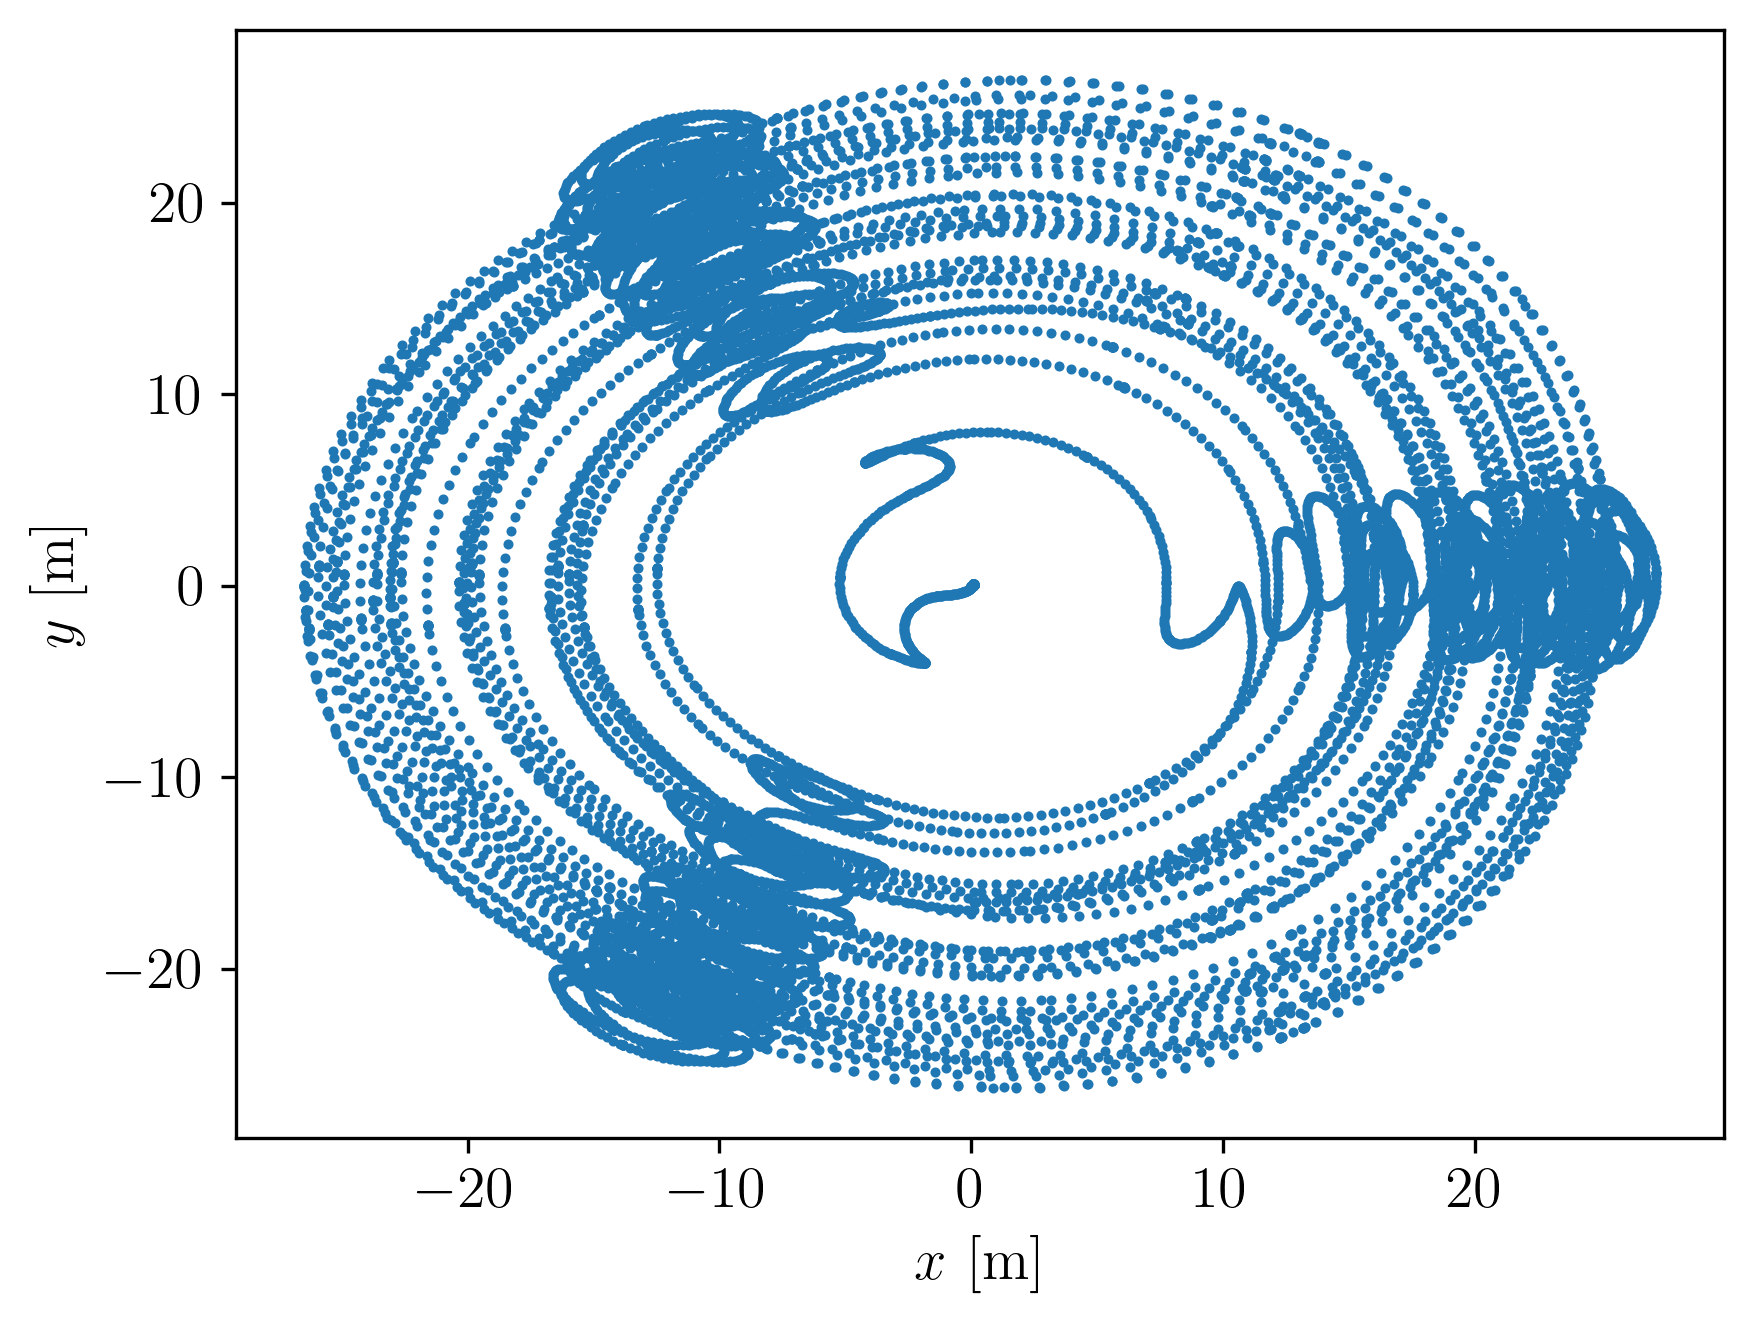

In [487]:
plt.scatter(ref_data['x'], ref_data['y'], s=2)
plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.show()

237 to 247

### Compute expected decay rate from reference particle

In [488]:
# Mass of muon [MeV/c^2]
mmu = 105.7

# Muon lifetime [seconds]
tau = 2.2e-6

In [489]:
# Function to calculate survival rate for time step:
def decays(p,s):
    E = np.sqrt(p**2+mmu**2)
    beta = p/E
    v = beta*3e8
    gamma = np.sqrt(1+p**2/mmu**2)
    d = s/v/gamma
    return np.exp(-d/tau)

In [490]:
# Iterate over time steps:
rates = []
rate = 1
stotal = 0
svals = []
zvals = []
pvals = []
for i in range(len(ref_data['t'])-1):
    dx = ref_data['x'][i+1] - ref_data['x'][i]
    dy = ref_data['y'][i+1] - ref_data['y'][i]
    dz = ref_data['z'][i+1] - ref_data['z'][i]
    ds = np.sqrt(dx**2 + dy**2 + dz**2)/1000 # mm-->m
    stotal += ds
    svals.append(stotal)
    p = ref_data['ptotal'][i]
    rate *= decays(p,ds)
    rates.append(rate)
    zvals.append(ref_data['z'].values[i])
    pvals.append(ref_data['ptotal'].values[i])

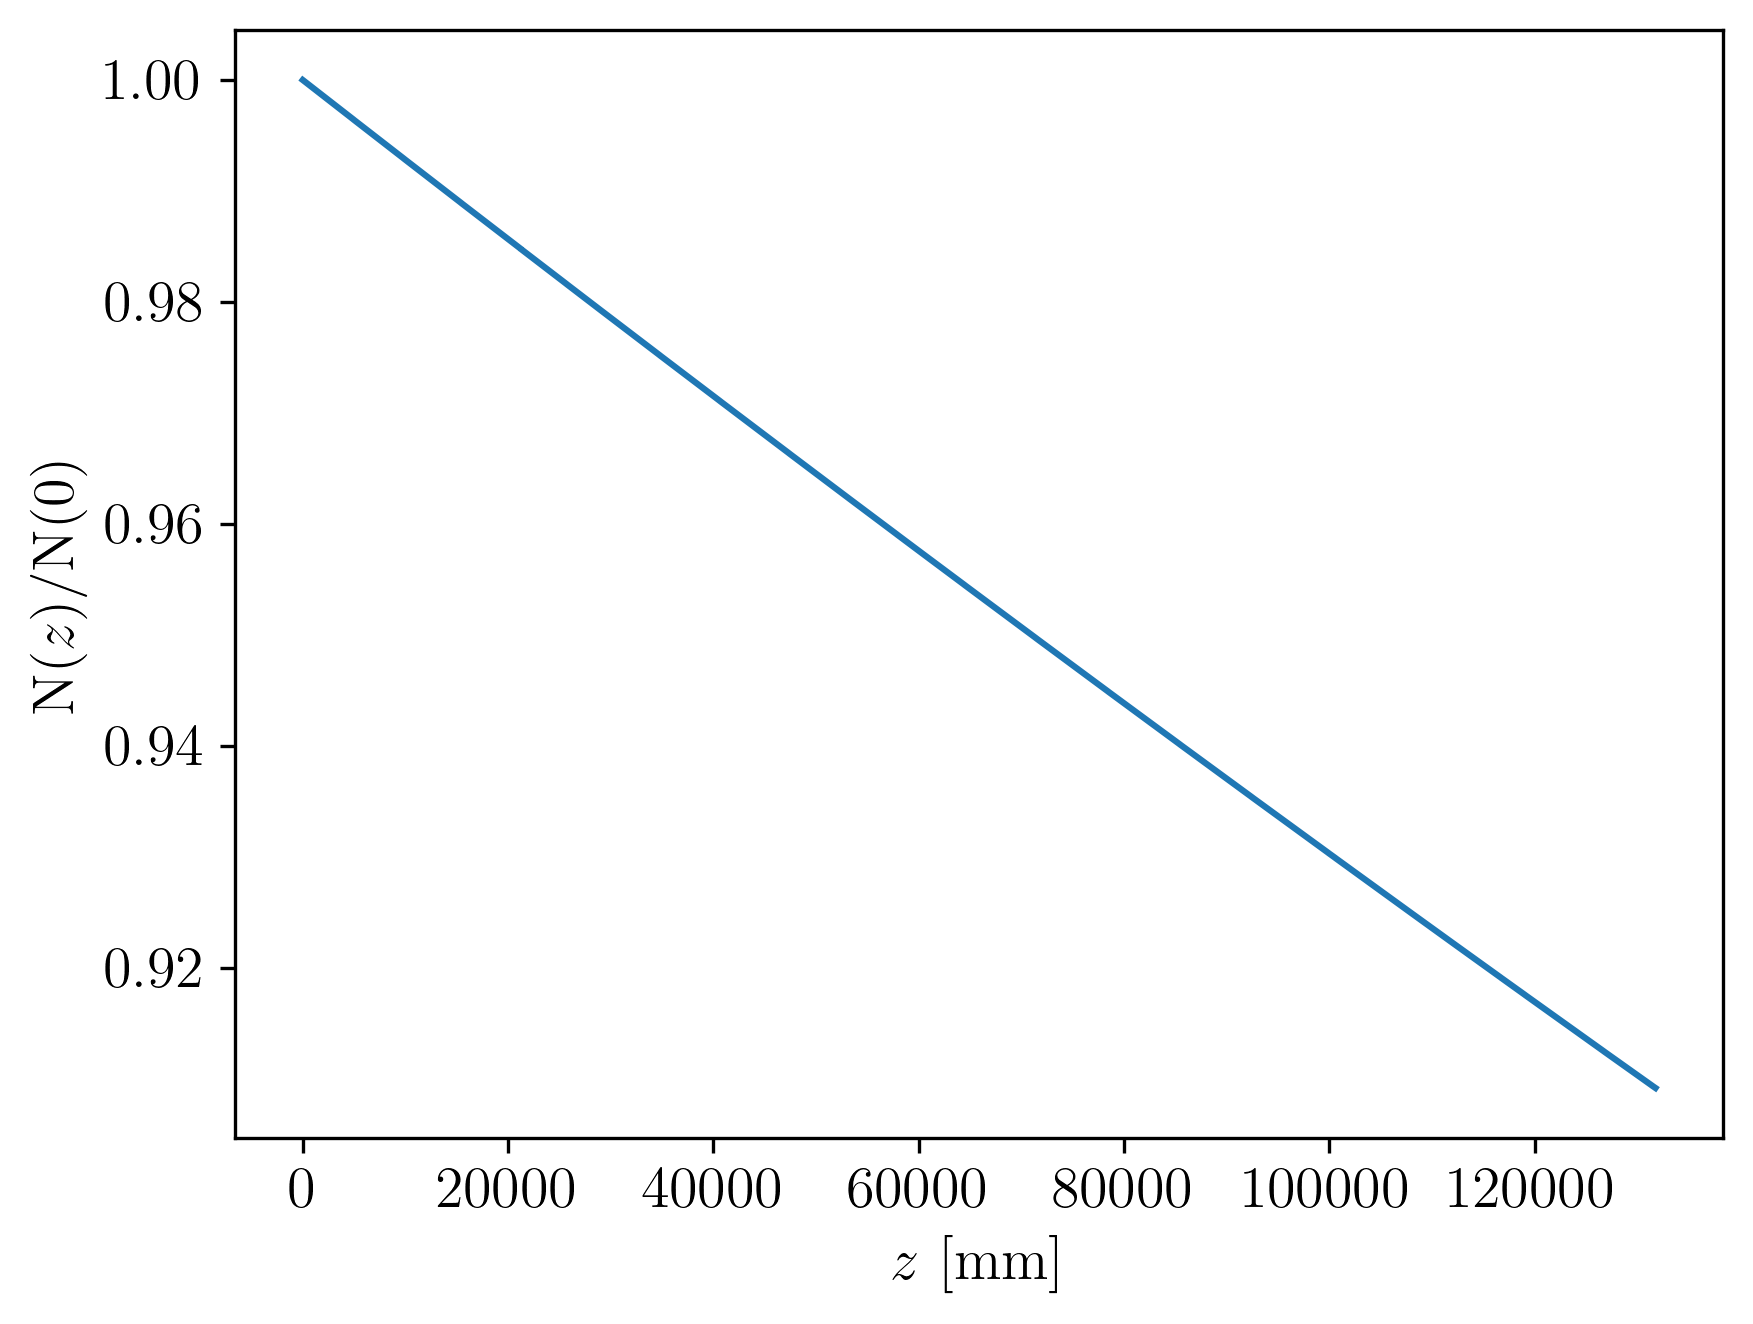

In [491]:
plt.plot(zvals,rates)
plt.ylabel('N($z$)/N(0)')
plt.xlabel('$z$ [mm]')
plt.show()

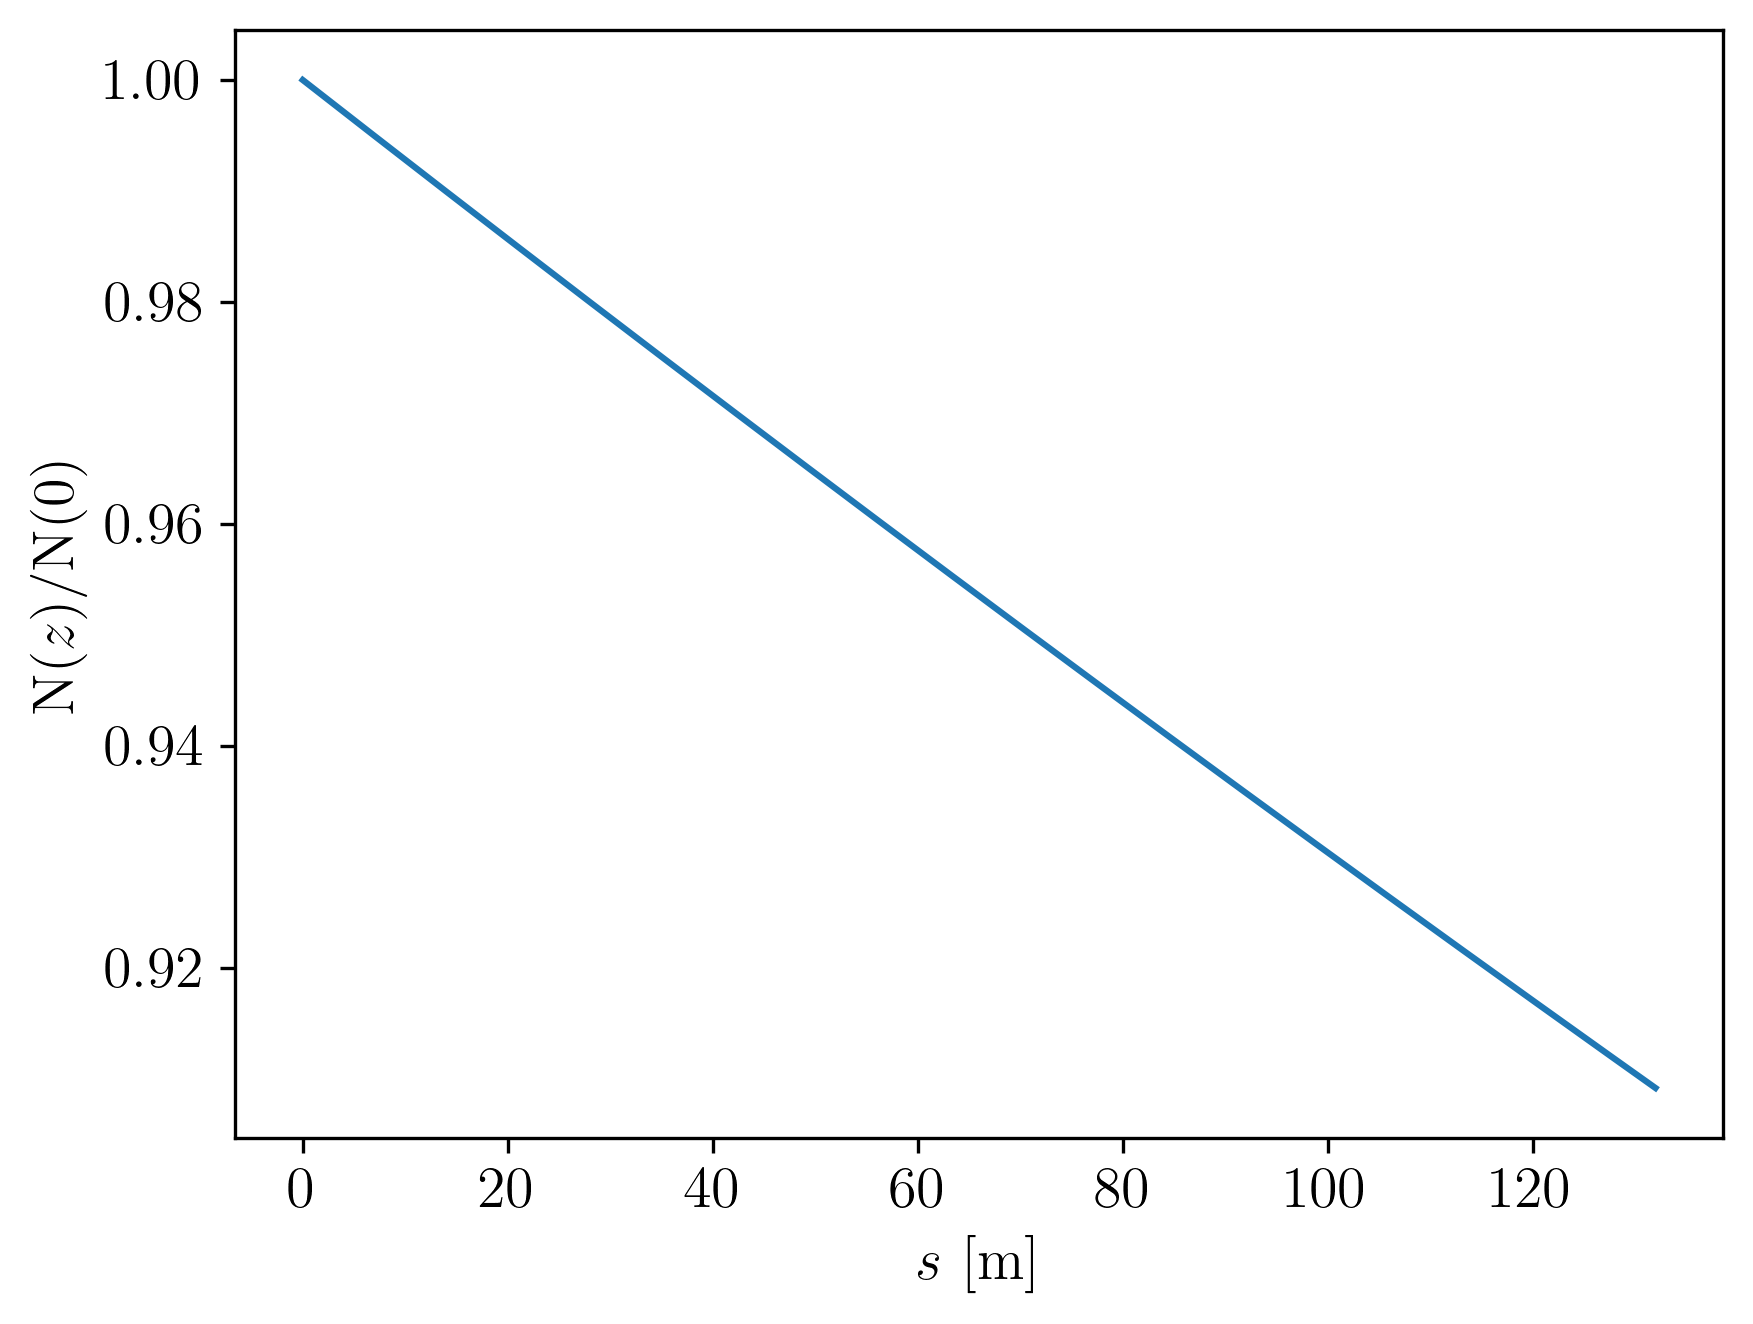

In [496]:
plt.plot(svals,rates)
plt.ylabel('N($z$)/N(0)')
plt.xlabel('$s$ [m]')
plt.show()

In [504]:
rates[len(rates)-1]

np.float64(0.9091514935600759)

In [493]:
np.max(zvals)

np.float64(131752.0)

In [494]:
stotal*1000

np.float64(131906.44337619958)

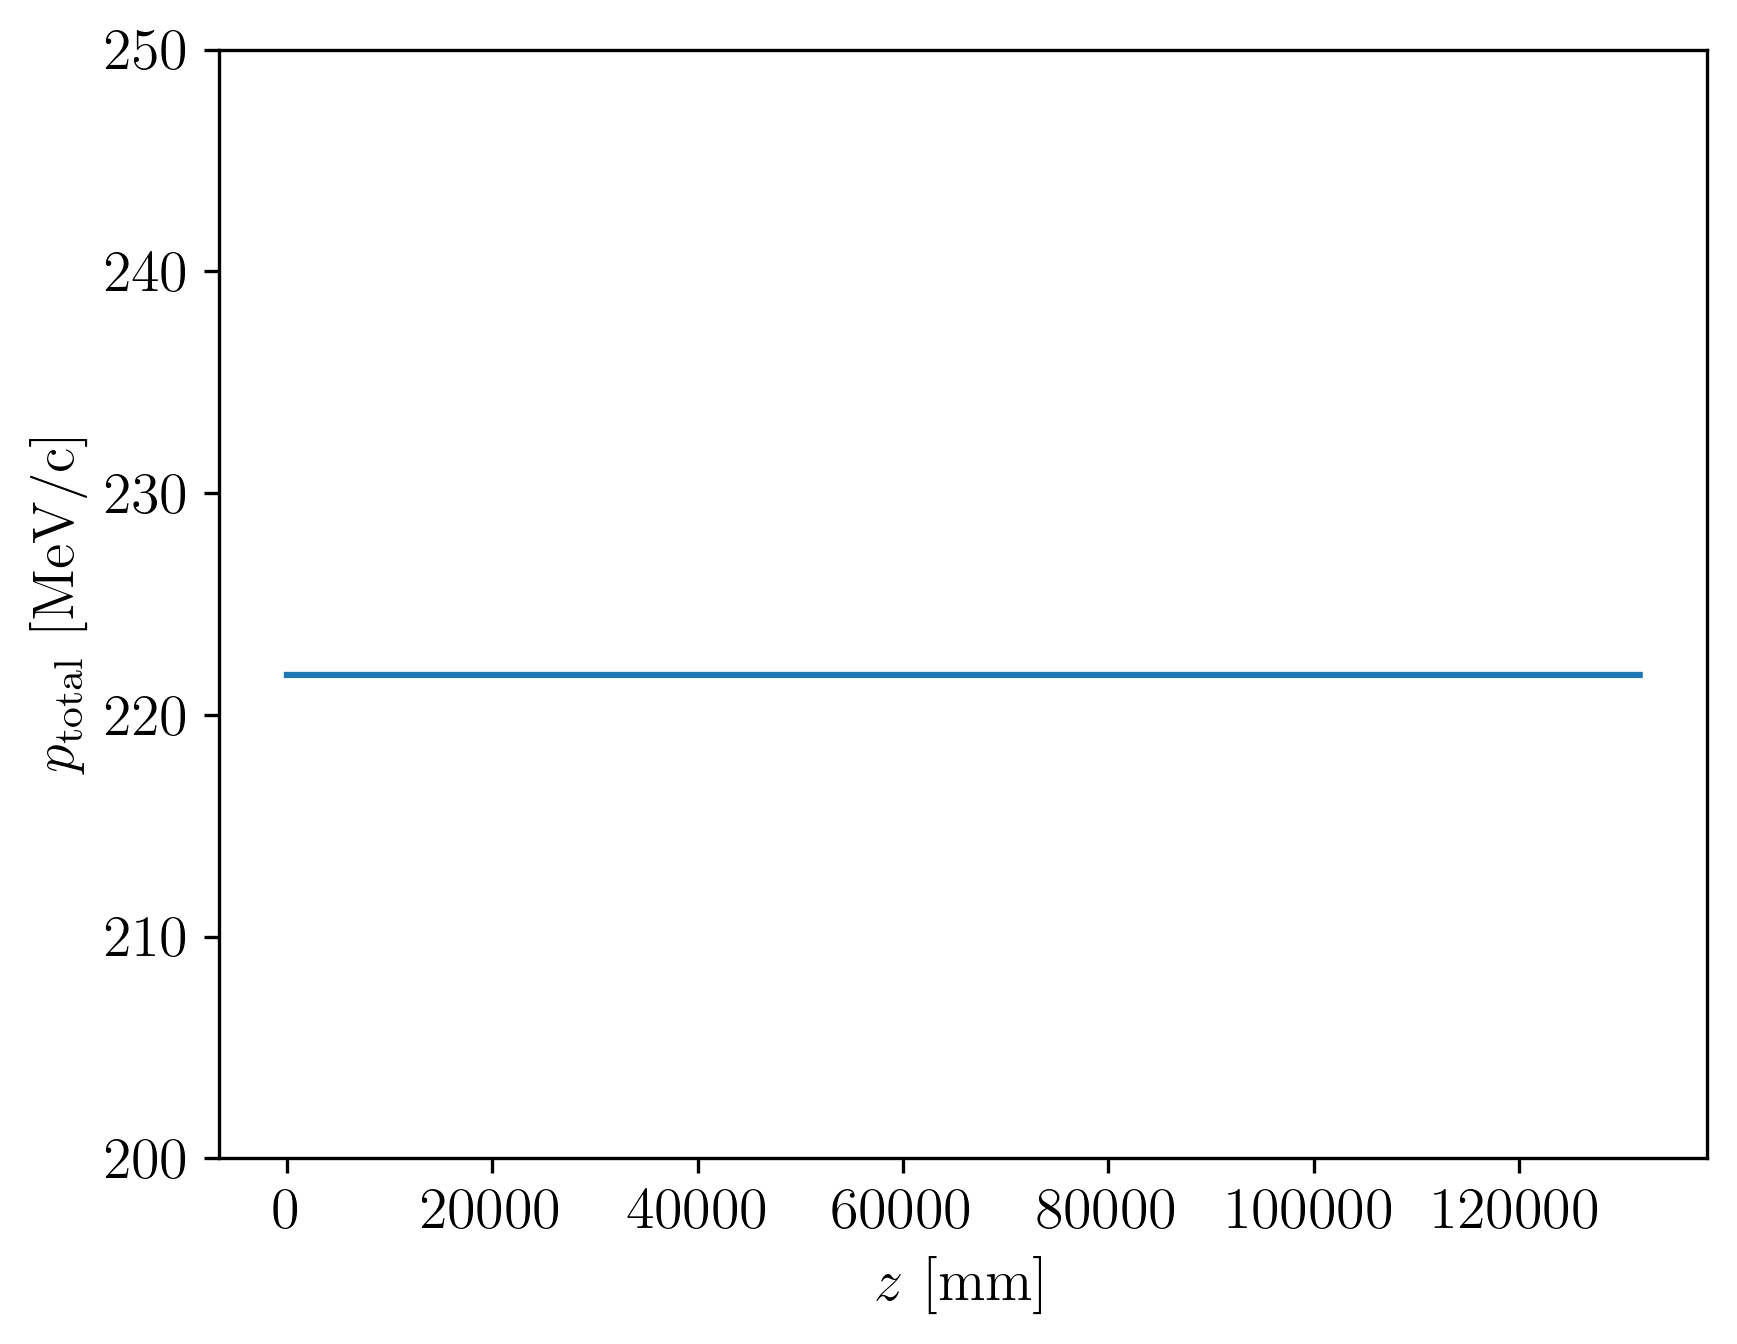

In [495]:
plt.plot(zvals,pvals)
plt.ylim(200,250)
plt.xlabel('$z$ [mm]')
plt.ylabel('$p_{\mathrm{total}}$ [MeV/c]')
plt.show()

### Subplot

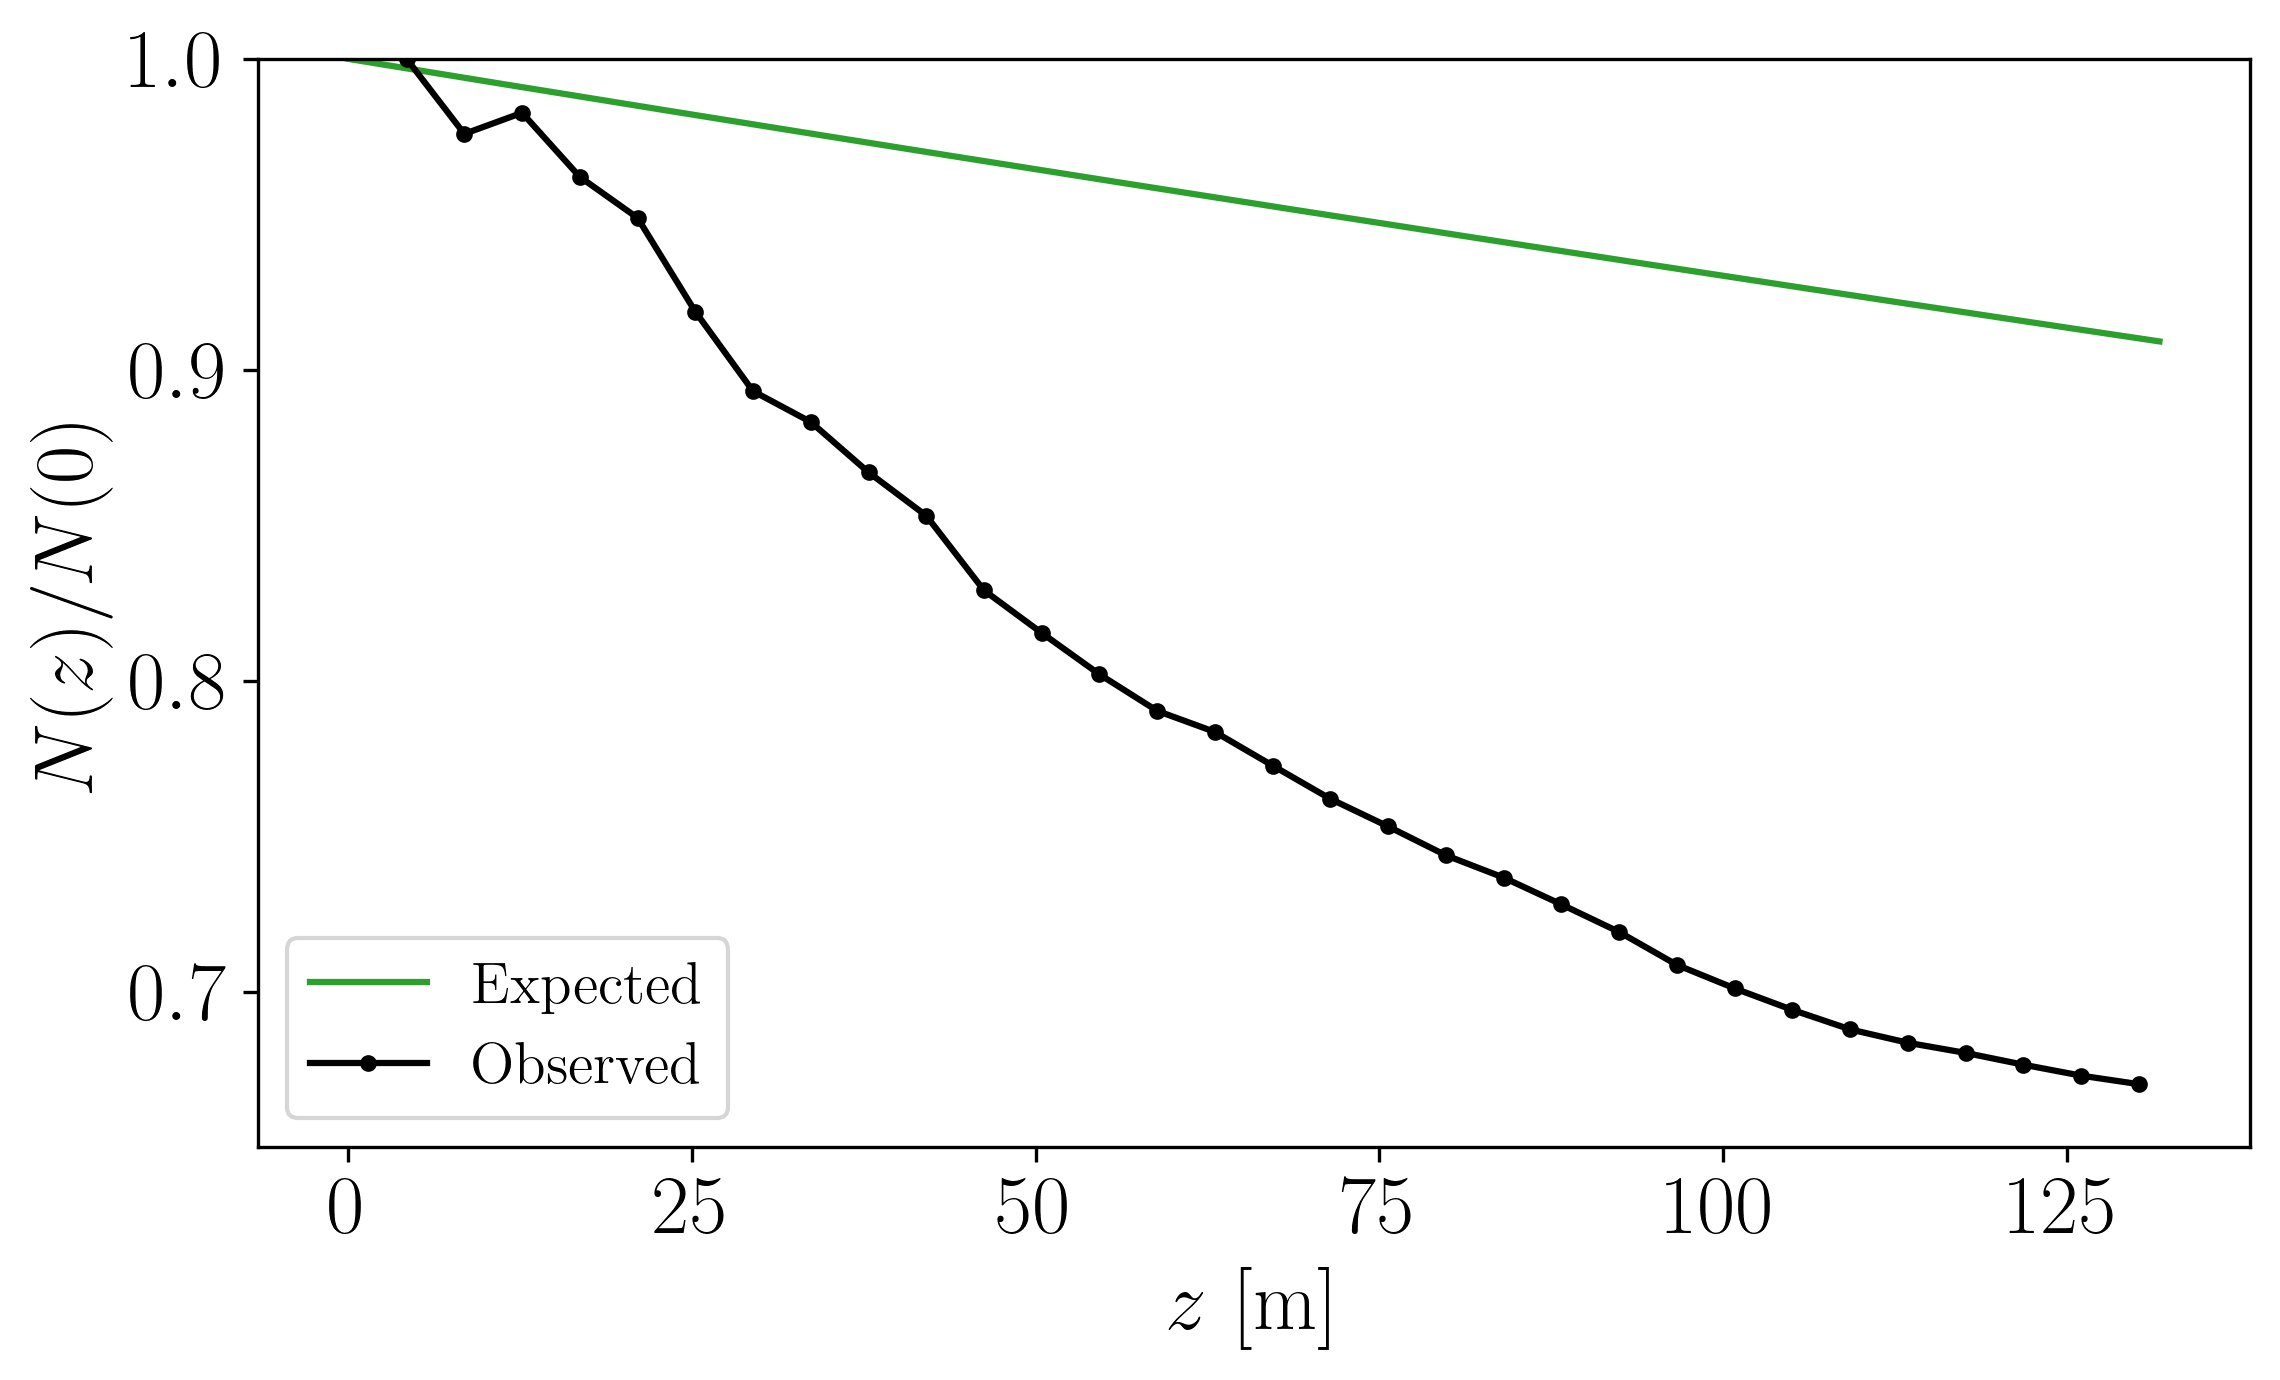

In [512]:
plt.rcParams.update({'font.size': 20})

z_vals_m = [i[0]/1000 for i in z_vals]
trans = [(len(i)/len(z_vals[0])) for i in z_vals]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot([z/1000 for z in zvals],rates,color='tab:green',label='Expected')
plt.plot(z_vals_m,trans,marker='.',color='black',label='Observed')
plt.xlabel('$z$ [m]')
plt.ylabel('$N(z)/N(0)$')
plt.ylim((0.65,1))
plt.tight_layout()
plt.legend(fontsize=14, loc='lower left')
plt.savefig(fig_dir+'transmission_rate.pdf')
plt.show()